# **Movies Dataset Analysis**

## **Collaborators** 
- Ashna Sood 
- Urmi Suresh
- Tae Kim 
- Xianglong Wang

## **Imports** 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import os 
import pickle

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats

from sklearn.metrics import make_scorer, accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from nltk.stem.snowball import SnowballStemmer

from sklearn import metrics

# from google.colab import drive
# from google.colab import files

In [2]:
# mount Google Drive to save results
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# upload a kaggle api key and set it to be used
# files.upload()
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
# use the kaggle api to download the dataset we'll be using
# !kaggle datasets download -d rounakbanik/the-movies-dataset
# !unzip the-movies-dataset.zip

 92% 209M/228M [00:07<00:00, 20.4MB/s]
100% 228M/228M [00:07<00:00, 31.9MB/s]
Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


## **Data Cleaning**

In [2]:
# read in movies metadata 
movies_df = pd.read_csv('Movies Data/movies_metadata.csv')

# drop unecessary metadata
movies_df = movies_df.drop(columns=["adult", "budget", "homepage", "original_title", "overview", "poster_path", "status", "tagline", "video"])


# change column names
movies_df = movies_df.rename(columns={"belongs_to_collection":"Collection", 
                                      "genres":"Genres", 
                                      "id":"ID", 
                                      "imdb_id":"IMDB ID", 
                                      "original_language":"Language", 
                                      "popularity":"Popularity Rating", 
                                      "production_companies":"Production Companies", 
                                      "production_countries":"Production Countries", 
                                      "release_date":"Release Date", 
                                      "revenue":"Revenue", "runtime":"Runtime", 
                                      "spoken_languages":"Spoken Languages", 
                                      "title":"Title", 
                                      "vote_average":"Vote Average", 
                                      "vote_count":"Vote Count"})

# remove duplicate movies present in the df keeping the movie with a higher vote count
movies_df = movies_df.sort_values('Vote Count').drop_duplicates('Title', keep='last')

# reorder columns 
movies_df = movies_df[["ID", "IMDB ID", "Title", "Collection", "Genres", "Language", "Spoken Languages", "Release Date", 
                       "Runtime", "Revenue", "Production Companies", "Production Countries", 
                       "Popularity Rating", "Vote Count", "Vote Average"]]

movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average
45465,461257,tt6980792,Queerama,NaN,[],en,"[{'iso_639_1': 'en', 'name': 'English'}]",2017-06-09,75.0,0.000000e+00,[],"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",0.163015,0.0,0.0
23677,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,0.000000e+00,[],[],0.3265,0.0,0.0
23671,114838,tt0029949,Brother Rat,NaN,"[{'id': 35, 'name': 'Comedy'}]",en,"[{'iso_639_1': 'en', 'name': 'English'}]",1938-10-29,87.0,0.000000e+00,"[{'name': 'Warner Bros.', 'id': 6194}]","[{'iso_3166_1': 'US', 'name': 'United States o...",0.174691,0.0,0.0
23663,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,0.000000e+00,[],[],0.000115,0.0,0.0
23648,88061,tt0055459,"So Evil, So Young",NaN,"[{'id': 18, 'name': 'Drama'}]",en,"[{'iso_639_1': 'en', 'name': 'English'}]",1963-01-01,77.0,0.000000e+00,[],[],0.001662,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17818,24428,tt0848228,The Avengers,"{'id': 86311, 'name': 'The Avengers Collection...","[{'id': 878, 'name': 'Science Fiction'}, {'id'...",en,"[{'iso_639_1': 'en', 'name': 'English'}]",2012-04-25,143.0,1.519558e+09,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",89.8876,12000.0,7.4
14551,19995,tt0499549,Avatar,"{'id': 87096, 'name': 'Avatar Collection', 'po...","[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",2009-12-10,162.0,2.787965e+09,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",185.071,12114.0,7.2
12481,155,tt0468569,The Dark Knight,"{'id': 263, 'name': 'The Dark Knight Collectio...","[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",2008-07-16,152.0,1.004558e+09,"[{'name': 'DC Comics', 'id': 429}, {'name': 'L...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",123.167,12269.0,8.3
15480,27205,tt1375666,Inception,NaN,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",en,"[{'iso_639_1': 'en', 'name': 'English'}]",2010-07-14,148.0,8.255328e+08,"[{'name': 'Legendary Pictures', 'id': 923}, {'...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",29.1081,14075.0,8.1


In [3]:
# read in movie keywords
keywords_df = pd.read_csv('Movies Data/keywords.csv')

# rename columns
keywords_df = keywords_df.rename(columns={"id": "ID", 
                                          "keywords": "Keywords"})

In [4]:
# read in movie credits 
credits_df = pd.read_csv('Movies Data/credits.csv')

# rename columns
credits_df = credits_df.rename(columns={"cast": "Cast", 
                                        "crew": "Crew",
                                        "id": "ID"})

In [5]:
# merge tables
movies_df['ID'] = movies_df['ID'].astype(str)
keywords_df['ID'] = keywords_df['ID'].astype(str)
credits_df['ID'] = credits_df['ID'].astype(str)

movies_df = movies_df.merge(keywords_df, on="ID", how="left").merge(credits_df, on="ID", how="left")
movies_df.head(1)

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Crew
0,461257,tt6980792,Queerama,NaN,[],en,"[{'iso_639_1': 'en', 'name': 'English'}]",2017-06-09,75.0,0.0,[],"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",0.163015,0.0,0.0,[],[],"[{'credit_id': '593e676c92514105b702e68e', 'de..."


In [6]:
# cast types
movies_df['Release Date'] = pd.to_datetime(movies_df['Release Date'], errors='coerce')
movies_df['Popularity Rating'] = pd.to_numeric(movies_df['Popularity Rating'], errors='coerce')
movies_df['Vote Count'] = movies_df['Vote Count'].astype(np.int64, errors='ignore')

# replace unreasonable values with NaN
movies_df['Revenue'] = movies_df['Revenue'].replace(0, np.nan)
movies_df['Popularity Rating'] = movies_df['Popularity Rating'].replace(0, np.nan)
movies_df['Vote Count'] = movies_df['Vote Count'].replace(0, np.nan)
movies_df['Vote Average'] = movies_df['Vote Average'].replace(0, np.nan)

In [7]:
# method to extract the director, screenplay writer, and producer from each movie
def extract_crew(crew):
    director, writer, producer = None, None, None
    for each in crew:

        if director and writer and producer:
            return [director, writer, producer]

        try:
            if (not director) and each['department']=='Directing' and each['job']=='Director':
                director = each['name']
                continue
                
        except:
          ...

        try:
            if (not writer) and each['department']=='Writing' and each['job']=='Screenplay' or each['job']=='Writer':
                writer = each['name']
                continue
        except:
            ...

        try:
            if (not producer) and each['department']=='Production' and (each['job']=='Producer' or each['job']=='Executive Producer'):
                producer = each['name']
                continue
        except:
            ...

    return [director, writer, producer]

In [8]:
# convert the Collections string literal into a dict and extract the name of the franchise 
movies_df["Collection"] = movies_df['Collection'].fillna('[]').apply(ast.literal_eval).apply(lambda x: x["name"] if isinstance(x, dict) else np.nan)

# extract genres out of string literal
movies_df['Genres'] = movies_df['Genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)

# extract spoken languages out of string literal
movies_df['Spoken Languages'] = movies_df['Spoken Languages'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['iso_639_1'] for i in x] if isinstance(x, list) else np.nan)

# extract Production Company out of string literal
movies_df['Production Companies'] = movies_df['Production Companies'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)

# extract Production Countries out of string literal
movies_df['Production Countries'] = movies_df['Production Countries'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)

# extract the keywords for each movie
movies_df["Keywords"] = movies_df["Keywords"].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)

# extract the names of at most the top 5 actors in each movie
movies_df["Cast"] = movies_df["Cast"].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else np.nan)
movies_df["Cast"] = movies_df["Cast"].apply(lambda x: x[:5] if len(x) > 5 else x)

# conver the Crew string literal into dict and extract the director, screenplay writer, and producer of each movie 
movies_df["Crew"] = movies_df["Crew"].fillna('[]').apply(ast.literal_eval)
movies_df['Director'], movies_df['Writer'], movies_df['Producer'] = [*zip(*np.array(movies_df['Crew'].apply(extract_crew)))]
movies_df = movies_df.drop('Crew', axis=1)

movies_df = movies_df.fillna(value=np.nan)

movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer
0,461257,tt6980792,Queerama,NaN,[],en,[en],2017-06-09,75.0,NaN,[],[United Kingdom],0.163015,NaN,NaN,[],[],Daisy Asquith,NaN,NaN
1,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,NaN,[],[],0.326500,NaN,NaN,[],"[Michael Ontkean, Ray Sharkey, Margot Kidder]",Paul Mazursky,Paul Mazursky,NaN
2,114838,tt0029949,Brother Rat,NaN,[Comedy],en,[en],1938-10-29,87.0,NaN,[Warner Bros.],[United States of America],0.174691,NaN,NaN,"[based on play or musical, virginia military i...","[Ronald Reagan, Jane Wyman, Priscilla Lane, Wa...",William Keighley,Jerry Wald,NaN
3,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,NaN,[],[],0.000115,NaN,NaN,[],[],Gérard Blain,NaN,NaN
4,88061,tt0055459,"So Evil, So Young",NaN,[Drama],en,[en],1963-01-01,77.0,NaN,[],[],0.001662,NaN,NaN,"[prison, women's prison]","[Jill Ireland, Ellen Pollock, Joan Haythorne, ...",Godfrey Grayson,Mark Grantham,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43246,24428,tt0848228,The Avengers,The Avengers Collection,"[Science Fiction, Action, Adventure]",en,[en],2012-04-25,143.0,1.519558e+09,"[Paramount Pictures, Marvel Studios]",[United States of America],89.887648,12000.0,7.4,"[new york, shield, marvel comic, superhero, ba...","[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",Joss Whedon,Joss Whedon,Stan Lee
43247,19995,tt0499549,Avatar,Avatar Collection,"[Action, Adventure, Fantasy, Science Fiction]",en,"[en, es]",2009-12-10,162.0,2.787965e+09,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",185.070892,12114.0,7.2,"[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,James Cameron,James Cameron
43248,155,tt0468569,The Dark Knight,The Dark Knight Collection,"[Drama, Action, Crime, Thriller]",en,"[en, zh]",2008-07-16,152.0,1.004558e+09,"[DC Comics, Legendary Pictures, Warner Bros., ...","[United Kingdom, United States of America]",123.167259,12269.0,8.3,"[dc comics, crime fighter, secret identity, sc...","[Christian Bale, Michael Caine, Heath Ledger, ...",Christopher Nolan,Christopher Nolan,Charles Roven
43249,27205,tt1375666,Inception,NaN,"[Action, Thriller, Science Fiction, Mystery, A...",en,[en],2010-07-14,148.0,8.255328e+08,"[Legendary Pictures, Warner Bros., Syncopy]","[United Kingdom, United States of America]",29.108149,14075.0,8.1,"[loss of lover, dream, kidnapping, sleep, subc...","[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...",Christopher Nolan,Christopher Nolan,Christopher Nolan


## **EDA**

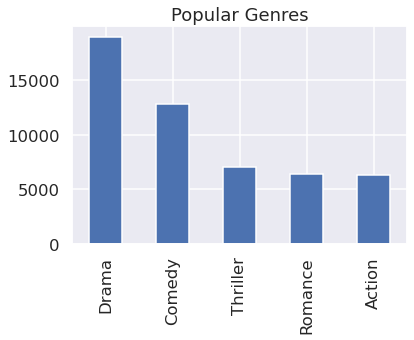

In [81]:
# see the top 5 genres in the dataset
genre_counts = pd.Series(movies_df['Genres'].sum()).value_counts()
genre_counts.head(5).plot(kind='bar', title='Popular Genres')

In [82]:
# count NaN in each column
movies_df.isna().sum()

# Collection: most movies don't belong to a series 
# Revenue: missing data

ID                          0
IMDB ID                    14
Title                       1
Collection              38815
Genres                      0
Language                   11
Spoken Languages            0
Release Date               84
Runtime                   258
Revenue                 35997
Production Companies        1
Production Countries        1
Popularity Rating          67
Vote Count               2756
Vote Average             2844
Keywords                    0
Cast                        0
Director                  889
Writer                   9822
Producer                21552
dtype: int64

In [83]:
# see various languages movies were shot in
# mainly movies in English 
movies_df["Language"].value_counts().head(5)

en    30567
fr     2347
it     1496
ja     1341
de     1029
Name: Language, dtype: int64

In [84]:
# franchise movies
movies_fran = movies_df[movies_df['Collection'].notnull()]
'%d many movies belong to a collection' % movies_fran.shape[0]

'4436 many movies belong to a collection'

In [85]:
# revenue by collection
movies_fran_pivot = movies_fran.pivot_table(index='Collection', values='Revenue', aggfunc={'Revenue': [np.mean, np.sum, 'count']})
movies_fran_pivot = movies_fran_pivot.sort_values('sum', ascending=False).reset_index()
movies_fran_pivot.head(20)

,Collection,count,mean,sum
0,Harry Potter Collection,8,9.634209e+08,7.707367e+09
1,Star Wars Collection,8,9.293118e+08,7.434495e+09
2,James Bond Collection,25,2.826090e+08,7.065226e+09
3,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
4,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09
5,Transformers Collection,5,8.732202e+08,4.366101e+09
6,Despicable Me Collection,4,9.227676e+08,3.691070e+09
7,The Twilight Collection,5,6.684215e+08,3.342107e+09
8,Ice Age Collection,5,6.433417e+08,3.216709e+09
9,Jurassic Park Collection,4,7.578710e+08,3.031484e+09


In [86]:
# popularity rating 
movies_fran_pivot2 = movies_fran.pivot_table(index='Collection', values='Popularity Rating', aggfunc={'Popularity Rating': [np.mean, np.sum]})
movies_fran_pivot2 = movies_fran_pivot2.sort_values('sum', ascending=False).reset_index()
movies_fran_pivot2.head(20)

,Collection,mean,sum
0,Despicable Me Collection,106.715961,640.295768
1,James Bond Collection,13.459622,336.490544
2,Wonder Woman Collection,294.337037,294.337037
3,Pirates of the Caribbean Collection,53.972237,269.861183
4,Planet of the Apes (Reboot) Collection,87.720253,263.160759
5,Guardians of the Galaxy Collection,119.311296,238.622593
6,John Wick Collection,116.558939,233.117879
7,The Hunger Games Collection,54.766748,219.066990
8,Harry Potter Collection,26.253893,210.031146
9,Avatar Collection,95.545473,191.090947


## **Content Based Recommender System**

In [9]:
movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,Production Companies,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer
0,461257,tt6980792,Queerama,NaN,[],en,[en],2017-06-09,75.0,NaN,[],[United Kingdom],0.163015,NaN,NaN,[],[],Daisy Asquith,NaN,NaN
1,92323,tt0081758,Willie and Phil,NaN,[],en,[],1980-08-15,115.0,NaN,[],[],0.326500,NaN,NaN,[],"[Michael Ontkean, Ray Sharkey, Margot Kidder]",Paul Mazursky,Paul Mazursky,NaN
2,114838,tt0029949,Brother Rat,NaN,[Comedy],en,[en],1938-10-29,87.0,NaN,[Warner Bros.],[United States of America],0.174691,NaN,NaN,"[based on play or musical, virginia military i...","[Ronald Reagan, Jane Wyman, Priscilla Lane, Wa...",William Keighley,Jerry Wald,NaN
3,264723,tt0070580,Le pélican,NaN,[],en,[],1974-02-06,83.0,NaN,[],[],0.000115,NaN,NaN,[],[],Gérard Blain,NaN,NaN
4,88061,tt0055459,"So Evil, So Young",NaN,[Drama],en,[en],1963-01-01,77.0,NaN,[],[],0.001662,NaN,NaN,"[prison, women's prison]","[Jill Ireland, Ellen Pollock, Joan Haythorne, ...",Godfrey Grayson,Mark Grantham,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43246,24428,tt0848228,The Avengers,The Avengers Collection,"[Science Fiction, Action, Adventure]",en,[en],2012-04-25,143.0,1.519558e+09,"[Paramount Pictures, Marvel Studios]",[United States of America],89.887648,12000.0,7.4,"[new york, shield, marvel comic, superhero, ba...","[Robert Downey Jr., Chris Evans, Mark Ruffalo,...",Joss Whedon,Joss Whedon,Stan Lee
43247,19995,tt0499549,Avatar,Avatar Collection,"[Action, Adventure, Fantasy, Science Fiction]",en,"[en, es]",2009-12-10,162.0,2.787965e+09,"[Ingenious Film Partners, Twentieth Century Fo...","[United States of America, United Kingdom]",185.070892,12114.0,7.2,"[culture clash, future, space war, space colon...","[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,James Cameron,James Cameron
43248,155,tt0468569,The Dark Knight,The Dark Knight Collection,"[Drama, Action, Crime, Thriller]",en,"[en, zh]",2008-07-16,152.0,1.004558e+09,"[DC Comics, Legendary Pictures, Warner Bros., ...","[United Kingdom, United States of America]",123.167259,12269.0,8.3,"[dc comics, crime fighter, secret identity, sc...","[Christian Bale, Michael Caine, Heath Ledger, ...",Christopher Nolan,Christopher Nolan,Charles Roven
43249,27205,tt1375666,Inception,NaN,"[Action, Thriller, Science Fiction, Mystery, A...",en,[en],2010-07-14,148.0,8.255328e+08,"[Legendary Pictures, Warner Bros., Syncopy]","[United Kingdom, United States of America]",29.108149,14075.0,8.1,"[loss of lover, dream, kidnapping, sleep, subc...","[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...",Christopher Nolan,Christopher Nolan,Christopher Nolan


In [9]:
# clean up keywords 
keywords = movies_df.apply(lambda x: pd.Series(x["Keywords"]), axis = 1).stack().reset_index(level = 1, drop = True)
keywords = keywords.value_counts()
keywords = keywords[keywords >= 3]
keywords

woman director      2904
independent film    1825
murder              1201
based on novel       761
musical              681
                    ... 
youtube                3
taser                  3
route 66               3
exchange               3
locomotive             3
Length: 7986, dtype: int64

In [10]:
def select_keywords(words):
  final_words = []
  for word in words:
    if word in keywords:
      final_words.append(word)
  return final_words

In [11]:
# only keep keywords that have frequency greater than 3
movies_df["Keywords"] = movies_df["Keywords"].apply(select_keywords).apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [12]:
# Collection - remove whitespace and convert to lowercase 
movies_df["Collection"] = movies_df["Collection"].str.lower().str.replace(" ", "")

# Cast - remove whitespace and convert to lowercase 
movies_df["Cast"] = movies_df["Cast"].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

# Director - remove whitespace and convert to lowercase 
movies_df["Director"] = movies_df["Director"].str.lower().str.replace(" ", "")

# Writer - remove whitespace and convert to lowercase 
movies_df["Writer"] = movies_df["Writer"].str.lower().str.replace(" ", "")

# Producer - remove whitespace and convert to lowercase 
movies_df["Producer"] = movies_df["Producer"].str.lower().str.replace(" ", "")

In [13]:
# replace NAN with empty space 
movies_df["Collection"] = movies_df["Collection"].fillna('')
movies_df["Director"] = movies_df["Director"].fillna('')
movies_df["Writer"] = movies_df["Writer"].fillna('')
movies_df["Producer"] = movies_df["Producer"].fillna('')

In [14]:
# experimenting with giving more weight to director
movies_df["Director"] = movies_df["Director"].apply(lambda x: f"{x} {x} {x}")

# combine all string metadata
movies_df["Metadata"] = movies_df["Director"] + " " + movies_df["Writer"] + " " + movies_df["Producer"] + " " + movies_df["Collection"]

# combine list metadata
movies_df["Metadata2"] = movies_df["Genres"] + movies_df["Cast"] + movies_df["Keywords"]
movies_df["Metadata2"] = movies_df["Metadata2"].apply(lambda x: " ".join(x))

# merge all metadata to one column 
movies_df["Metadata"] = movies_df["Metadata"] + movies_df["Metadata2"]
# drop second metadata col
movies_df = movies_df.drop(columns=["Metadata2"])
movies_df

,ID,IMDB ID,Title,Collection,Genres,Language,Spoken Languages,Release Date,Runtime,Revenue,...,Production Countries,Popularity Rating,Vote Count,Vote Average,Keywords,Cast,Director,Writer,Producer,Metadata
0,461257,tt6980792,Queerama,,[],en,[en],2017-06-09,75.0,NaN,...,[United Kingdom],0.163015,NaN,NaN,[],[],daisyasquith daisyasquith daisyasquith,,,daisyasquith daisyasquith daisyasquith
1,92323,tt0081758,Willie and Phil,,[],en,[],1980-08-15,115.0,NaN,...,[],0.326500,NaN,NaN,[],"[michaelontkean, raysharkey, margotkidder]",paulmazursky paulmazursky paulmazursky,paulmazursky,,paulmazursky paulmazursky paulmazursky paulmaz...
2,114838,tt0029949,Brother Rat,,[Comedy],en,[en],1938-10-29,87.0,NaN,...,[United States of America],0.174691,NaN,NaN,[basedonplayormusical],"[ronaldreagan, janewyman, priscillalane, wayne...",williamkeighley williamkeighley williamkeighley,jerrywald,,williamkeighley williamkeighley williamkeighle...
3,264723,tt0070580,Le pélican,,[],en,[],1974-02-06,83.0,NaN,...,[],0.000115,NaN,NaN,[],[],gérardblain gérardblain gérardblain,,,gérardblain gérardblain gérardblain
4,88061,tt0055459,"So Evil, So Young",,[Drama],en,[en],1963-01-01,77.0,NaN,...,[],0.001662,NaN,NaN,"[prison, women'sprison]","[jillireland, ellenpollock, joanhaythorne, oli...",godfreygrayson godfreygrayson godfreygrayson,markgrantham,,godfreygrayson godfreygrayson godfreygrayson m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43246,24428,tt0848228,The Avengers,theavengerscollection,"[Science Fiction, Action, Adventure]",en,[en],2012-04-25,143.0,1.519558e+09,...,[United States of America],89.887648,12000.0,7.4,"[newyork, shield, marvelcomic, superhero, base...","[robertdowneyjr., chrisevans, markruffalo, chr...",josswhedon josswhedon josswhedon,josswhedon,stanlee,josswhedon josswhedon josswhedon josswhedon st...
43247,19995,tt0499549,Avatar,avatarcollection,"[Action, Adventure, Fantasy, Science Fiction]",en,"[en, es]",2009-12-10,162.0,2.787965e+09,...,"[United States of America, United Kingdom]",185.070892,12114.0,7.2,"[cultureclash, future, spacewar, spacecolony, ...","[samworthington, zoesaldana, sigourneyweaver, ...",jamescameron jamescameron jamescameron,jamescameron,jamescameron,jamescameron jamescameron jamescameron jamesca...
43248,155,tt0468569,The Dark Knight,thedarkknightcollection,"[Drama, Action, Crime, Thriller]",en,"[en, zh]",2008-07-16,152.0,1.004558e+09,...,"[United Kingdom, United States of America]",123.167259,12269.0,8.3,"[dccomics, crimefighter, secretidentity, scare...","[christianbale, michaelcaine, heathledger, aar...",christophernolan christophernolan christophern...,christophernolan,charlesroven,christophernolan christophernolan christophern...
43249,27205,tt1375666,Inception,,"[Action, Thriller, Science Fiction, Mystery, A...",en,[en],2010-07-14,148.0,8.255328e+08,...,"[United Kingdom, United States of America]",29.108149,14075.0,8.1,"[lossoflover, dream, kidnapping, sleep, subcon...","[leonardodicaprio, josephgordon-levitt, ellenp...",christophernolan christophernolan christophern...,christophernolan,christophernolan,christophernolan christophernolan christophern...


In [78]:
movies_df["Metadata"][12]

'williamhellfire williamhellfire williamhellfire  michaelraso Horror Fantasy erinbrown pattypeturbed joeysmack shower mummy masturbation'

In [15]:
# vectorize the movies' metadata
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
# tokenizes the strings and returns a vector for each string 
count_matrix = count.fit_transform(movies_df["Metadata"])

In [16]:
# calculate similarity between the movies
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [17]:
movies_df = movies_df.reset_index()
titles = movies_df['Title']
indices = pd.Series(movies_df.index, index=movies_df['Title'])

In [18]:
# code borrowed from kaggle notebook 
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:20]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [19]:
# new experimenting reccomender results 
get_recommendations("The Dark Knight")

43238           The Dark Knight Rises
43222                   Batman Begins
37476                       Doodlebug
37477                       Doodlebug
43106                    The Prestige
40629                       Following
43249                       Inception
42914                         Dunkirk
43083                         Memento
42300                        Insomnia
43244                    Interstellar
41092      Batman: Under the Red Hood
42633                  Batman Returns
40222       Batman: Assault on Arkham
43202                    Man of Steel
2147                  Evil Behind You
41164        Batman: The Killing Joke
27410           The Holcroft Covenant
36405    Batman & Mr. Freeze: SubZero
Name: Title, dtype: object

In [20]:
# new experimenting reccomender results 
get_recommendations("The Avengers")

43213                          Avengers: Age of Ultron
39722                   Dr. Horrible's Sing-Along Blog
42377                                         Serenity
43180              Captain America: The Winter Soldier
43189                                          Ant-Man
43140                             Thor: The Dark World
43221                       Captain America: Civil War
42818                           The Cabin in the Woods
43179                                   Doctor Strange
43214                                       Iron Man 2
43235                                         Iron Man
42973                              The Incredible Hulk
33576            Marvel Studios: Assembling a Universe
43208                                             Thor
43216               Captain America: The First Avenger
43236                                       Iron Man 3
43245                                         Deadpool
35783    Avengers Confidential: Black Widow & Punisher
34064     

In [22]:
get_recommendations("The Avengers")

43213                          Avengers: Age of Ultron
43180              Captain America: The Winter Soldier
43189                                          Ant-Man
43179                                   Doctor Strange
43140                             Thor: The Dark World
43221                       Captain America: Civil War
43214                                       Iron Man 2
43235                                         Iron Man
42973                              The Incredible Hulk
43208                                             Thor
37767                         Marvel One-Shot: Item 47
43236                                       Iron Man 3
33576            Marvel Studios: Assembling a Universe
43216               Captain America: The First Avenger
35783    Avengers Confidential: Black Widow & Punisher
28504        Iron Man & Captain America: Heroes United
43245                                         Deadpool
34064                   Iron Man & Hulk: Heroes United
37073     

In [21]:
# new experimenting reccomender results 
get_recommendations("Harry Potter and the Philosopher's Stone")

43185              Harry Potter and the Chamber of Secrets
38938                                          Nine Months
14112                                     Heartbreak Hotel
43163               Harry Potter and the Half-Blood Prince
42759    Percy Jackson & the Olympians: The Lightning T...
33019                                      Only the Lonely
43176                  Harry Potter and the Goblet of Fire
43190             Harry Potter and the Prisoner of Azkaban
39375                              I Love You, Beth Cooper
43171            Harry Potter and the Order of the Phoenix
42858                       Home Alone 2: Lost in New York
40138                                              Stepmom
42133                                     Bicentennial Man
42599                                       Mrs. Doubtfire
42864                                           Home Alone
42887                                               Pixels
38922                            Adventures in Babysitti

In [23]:
get_recommendations("Harry Potter and the Philosopher's Stone")

43185              Harry Potter and the Chamber of Secrets
43163               Harry Potter and the Half-Blood Prince
43176                  Harry Potter and the Goblet of Fire
43190             Harry Potter and the Prisoner of Azkaban
43171            Harry Potter and the Order of the Phoenix
43174         Harry Potter and the Deathly Hallows: Part 1
43193         Harry Potter and the Deathly Hallows: Part 2
1436                                           Bhoot Unkle
1442                                 Jill And Joy's Winter
7912                           A Journey Through Fairyland
16699                                 Wow! A Talking Fish!
42759    Percy Jackson & the Olympians: The Lightning T...
7367                                Puff, the Magic Dragon
8056                                        All She Wishes
864                           The Wonderful Ice Cream Suit
3888                                     Der Struwwelpeter
41182                                          Hocus Poc

In [24]:
# new experimenting reccomender results 
get_recommendations("Moana")

42649                                             Hercules
42109                                      Treasure Planet
40458                            The Great Mouse Detective
42384                            The Princess and the Frog
43028                                              Aladdin
8638     VeggieTales: Sheerluck Holmes and the Golden R...
42708                                   The Little Mermaid
1352                                      Green Legend Ran
6757                                           Dragon Hill
10256                                          Malice@Doll
12506                            Кентервильское привидение
5427                                           Cheburashka
8660                    VeggieTales: Josh and the Big Wall
13091    VeggieTales: Minnesota Cuke and the Search for...
11797                                      Superstar Goofy
8637                 VeggieTales: LarryBoy & The Bad Apple
8979              Spiderman: The Ultimate Villain Showdo

In [24]:
get_recommendations("Cinderella")

40886     Ever After: A Cinderella Story
36896        Three Wishes for Cinderella
42406                    Sleeping Beauty
31848        The Cave of the Golden Rose
10823                        Aşk Kırmızı
10824                        Aşk Kırmızı
39793    Cinderella III: A Twist in Time
10292          Cirque du Soleil: Varekai
15623                More Than a Miracle
13721        Prince and the Evening Star
39975    Cinderella II: Dreams Come True
837           Jails, Hospitals & Hip-Hop
1077                             Sundome
1436                         Bhoot Unkle
1442               Jill And Joy's Winter
2021                                Joni
2615                    Ill Gotten Gains
3887                             Το γάλα
4492                  Counting Backwards
Name: Title, dtype: object

### **Collaborative Filtering**

In [26]:
# read in movie ratings 
ratings_df = pd.read_csv('Movies Data/ratings.csv')

# rename columns
ratings_df = ratings_df.rename(columns={"userId": "User ID", 
                                        "movieId": "Movie ID", 
                                        "timestamp": "Timestamp"})

In [27]:
ratings_df

,User ID,Movie ID,rating,Timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990
